Trong lúc xóa các file để giảm dung lượng xuống 10gb do trường bị quá giới hạn dung lượng của tổ chức. Em đã xóa nhầm file HRNet gốc và không thể restore. Và vẫn chưa thể tạo file mới bằng tài khoản uit nên em lấy tk cá nhân để code lại. Mong thầy thông cảm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library

In [1]:
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16
# adam update
from tensorflow.keras.optimizers import legacy
import urllib.request
from PIL import Image
import warnings
from google.colab.patches import cv2_imshow

In [3]:
path = '/content/drive/MyDrive/CV++'
train_path = path + '/cityscapes_data/train'
val_path = path + '/cityscapes_data/val'

In [4]:

warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")

sns.set_context("paper", font_scale=1.4)

(256, 512, 3)


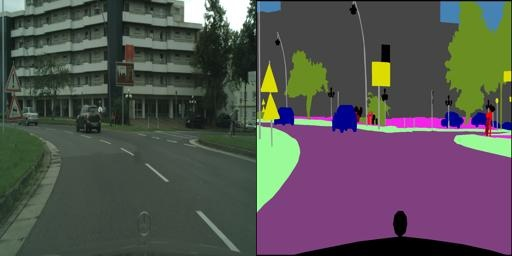

In [9]:
img = cv2.imread(train_path + '/1.jpg')
print(img.shape)
cv2_imshow(img)

In [12]:
cv2_imshow(img[220:240, 480:500])
print(img[220:240, 480:500])

[[[127  63 128]
  [127  63 128]
  [127  63 128]
  ...
  [125  65 125]
  [127  64 126]
  [127  64 126]]

 [[127  63 128]
  [127  63 128]
  [127  63 128]
  ...
  [125  65 125]
  [127  64 126]
  [127  64 126]]

 [[127  63 128]
  [127  63 128]
  [127  63 128]
  ...
  [125  65 125]
  [127  64 126]
  [127  64 126]]

 ...

 [[127  63 128]
  [127  63 128]
  [127  63 128]
  ...
  [125  65 125]
  [127  64 126]
  [127  64 126]]

 [[127  63 128]
  [127  63 128]
  [127  63 128]
  ...
  [125  65 125]
  [127  64 126]
  [127  64 126]]

 [[129  63 128]
  [129  63 128]
  [129  63 128]
  ...
  [125  65 126]
  [127  64 126]
  [127  63 128]]]


# Labels

In [ ]:
from collections import namedtuple
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )
#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'
          , 8       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),

    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),

    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),]
mapping_20 = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 1,
        8: 8,
        9: 1,
        10: 1,
        11: 2,
        12: 2,
        13: 2,
        14: 2,
        15: 2,
        16: 2,
        17: 3,
        18: 3,
        19: 3,
        20: 3,
        21: 4,
        22: 4,
        23: 5,
        24: 6,
        25: 6,
        26: 7,
        27: 7,
        28: 7,
        29: 7,
        30: 7,
        31: 7,
        32: 7,
        33: 7,
        -1: 7
    }


# Prepare data

In [ ]:
def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)

    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])
    image = image.resize(image_size)
    mask = mask.resize(image_size)

    image = np.array(image) / 255 # crop image section and reformat as normalized np array
    mask = np.array(mask) # crop mask section and reformat as np array

    return image, mask

def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000)
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)

    return closest_category

def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in mapping_20:
        label_mask[mask == k] = mapping_20[k]
    return label_mask

In [ ]:
def preprocess(path, img_size):
    image, mask = image_mask_split(path, img_size)
    mask_enc = find_closest_labels_vectorized(mask, id2color)
    return image, mask_enc, mask

In [ ]:
# save processed data to file for future use
def save_list_to_file(data, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)

In [ ]:
BATCH_SIZE = 16
id2color = { label.id : np.asarray(label.color) for label in labels }
num_classes = classes = len(id2color.keys())
width, height = 128, 128
IMAGE_SIZE = [width, height]
IMAGE_SHAPE = IMAGE_SIZE + [3,]

## Preprocess data

In [ ]:
# Store the images, the masks, and the encoded masks
train_images = []
train_masks = []
train_masks_enc = []
val_images = []
val_masks = []
val_masks_enc = []

In [ ]:
# train_images = np.zeros((2975,256,256,3) )
# train_masks_enc = np.zeros((2975,256,256))
# val_images = np.zeros((250,256,256,3))
# val_masks_enc = np.zeros((250,256,256))
# train_images.shape

In [ ]:
for train_file in tqdm(os.listdir(train_path), desc = 'Building Training Dataset: '):
    image, mask_enc, mask = preprocess(os.path.join(train_path, train_file), IMAGE_SIZE)
    train_images.append(image)
    train_masks.append(mask)
    train_masks_enc.append(mask_enc)

for val_file in tqdm(os.listdir(val_path), desc = 'Building Validation Dataset: '):
    image, mask_enc, mask = preprocess(os.path.join(val_path, val_file), IMAGE_SIZE)
    val_images.append(image)
    val_masks.append(mask)
    val_masks_enc.append(mask_enc)

## Save data

In [ ]:
# save_list_to_file(train_images, '/content/drive/MyDrive/CV++/data/train_images.pkl')
# save_list_to_file(train_masks, '/content/drive/MyDrive/CV++/data/train_masks.pkl')
# save_list_to_file(train_masks_enc, '/content/drive/MyDrive/CV++/data/train_masks_enc.pkl')

# save_list_to_file(val_images, '/content/drive/MyDrive/CV++/data/val_images.pkl')
# save_list_to_file(val_masks, '/content/drive/MyDrive/CV++/data/val_masks.pkl')
# save_list_to_file(val_masks_enc, '/content/drive/MyDrive/CV++/data/val_masks_enc.pkl')


## Load data

In [13]:
path_pkl = os.path.join(path,'data')
def load_list_from_file(file_path):

    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

train_images = np.array(load_list_from_file(os.path.join(path_pkl, 'train_images.pkl')))
train_masks = np.array(load_list_from_file(os.path.join(path_pkl, 'train_masks.pkl')))
train_masks_enc = np.array(load_list_from_file(os.path.join(path_pkl, 'train_masks_enc.pkl')))
val_images = np.array(load_list_from_file(os.path.join(path_pkl, 'val_images.pkl')))
val_masks = np.array(load_list_from_file(os.path.join(path_pkl, 'val_masks.pkl')))
val_masks_enc = np.array(load_list_from_file(os.path.join(path_pkl, 'val_masks_enc.pkl')))

In [17]:
print(np.max(train_masks_enc[0]))
print(np.min(train_masks_enc[0]))
train_masks_enc[0]

33
0


array([[27, 27, 11, ..., 11, 11, 11],
       [11, 11, 21, ..., 21, 21, 11],
       [11, 11, 21, ..., 21, 21, 21],
       ...,
       [6, 7, 7, ..., 7, 7, 7],
       [11, 7, 7, ..., 7, 7, 11],
       [27, 11, 11, ..., 11, 11, 6]], dtype=object)

## Plot some samples

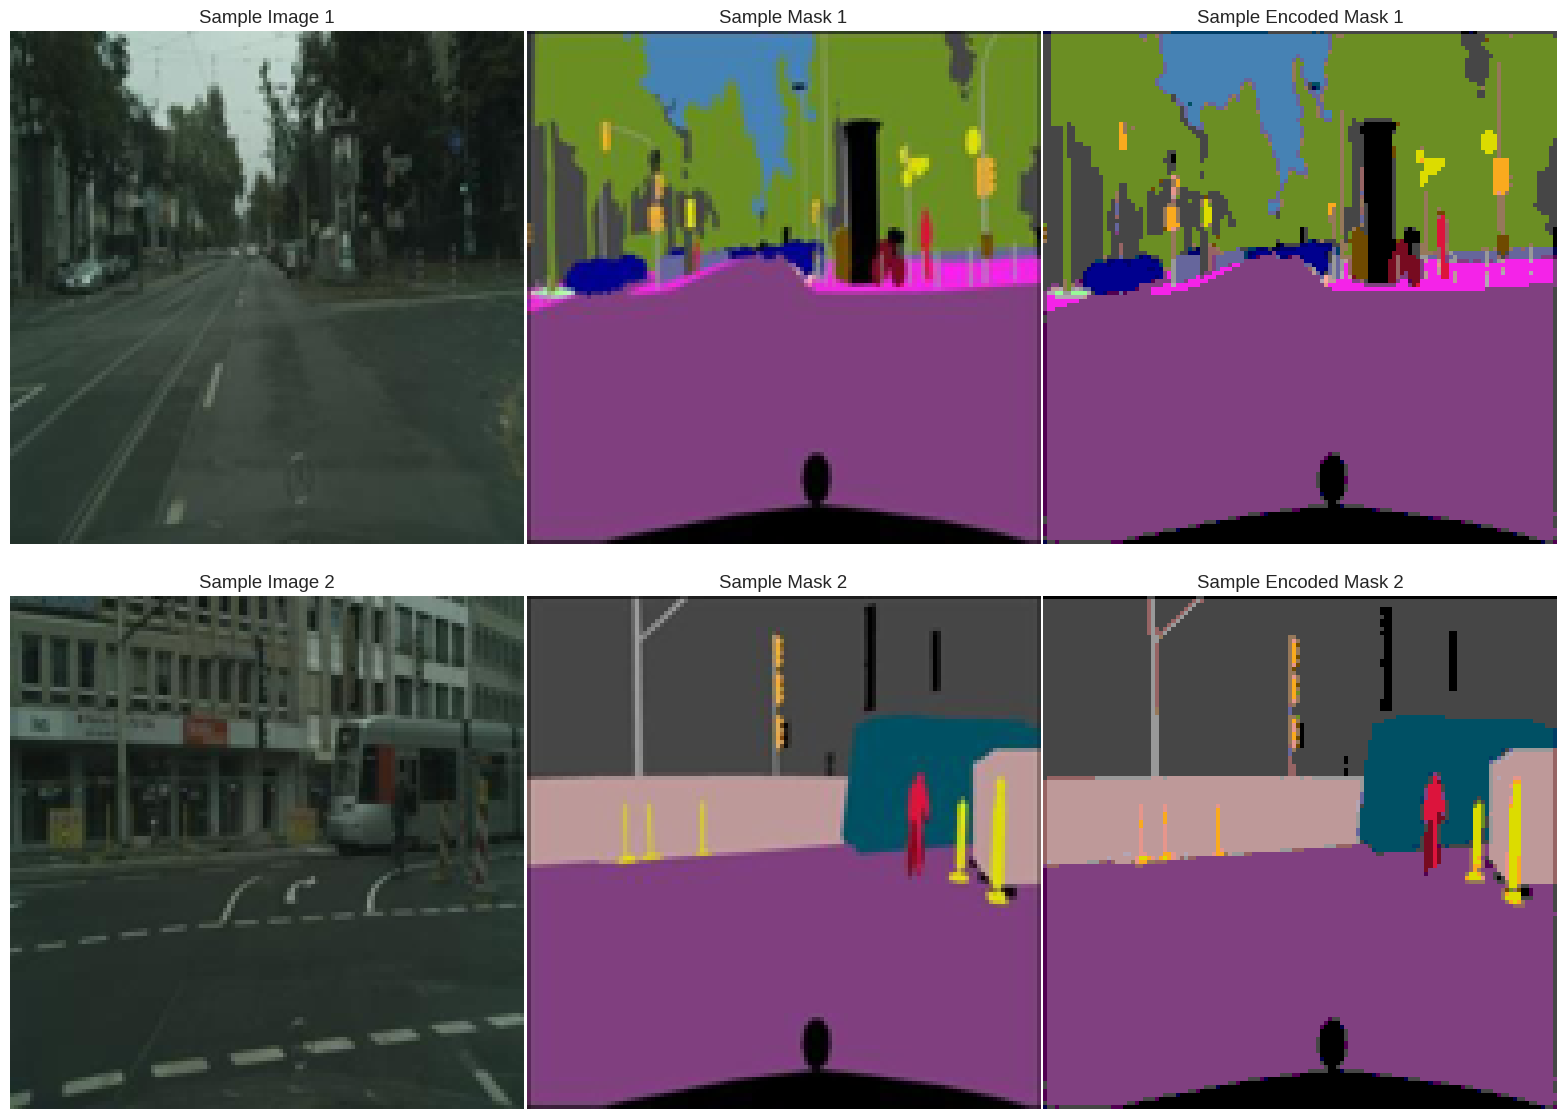

In [ ]:
plt.figure(figsize=[20, 14])

for i in range(2):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_enc[i]
    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])

    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[enc[row, col]]
            tmp = tmp.astype('uint8')
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Sample Image {}'.format(str(i+1)))

    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.gca().set_title('Sample Mask {}'.format(str(i+1)))

    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title('Sample Encoded Mask {}'.format(str(i+1)))

plt.subplots_adjust(wspace=0, hspace=0.1)

In [ ]:
train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')
val_images = np.stack(val_images).astype('float32')
val_masks_enc = np.stack(val_masks_enc).astype('float32')

In [ ]:
train_images.shape

(3036, 128, 128, 3)

# **Model**

## Build model


In [ ]:
def bottle_neck(inputs):
  res = inputs
  x = layers.Conv2D(64,kernel_size=1,padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)

  x2 = layers.Conv2D(64,kernel_size=3,padding='same')(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = tf.keras.activations.relu(x2)

  x3 = layers.Conv2D(128,kernel_size=1,padding='same')(x2)
  x3 = layers.BatchNormalization()(x3)
  x3 = tf.keras.activations.relu(x3)
  res = layers.Conv2D(128 , kernel_size =1 , padding = 'same')(res)
  output = x3+res
  output = tf.keras.activations.relu(output)
  return output

def basic_block(inputs,num_channels,stride,padding):
  res = inputs

  x = layers.Conv2D(num_channels,kernel_size=3,strides=stride,padding = padding)(inputs)
  x = layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)

  x2 = layers.Conv2D(num_channels,kernel_size=3,strides=1,padding = padding)(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = tf.keras.activations.relu(x2)

  return x2

In [ ]:
input_shape = keras.Input(shape=(width, height, 3))

x1 = bottle_neck(input_shape)
x1 = bottle_neck(x1)

x21 = basic_block(x1,x1.shape[3],1,'same')
x21 = basic_block(x21,x21.shape[3],1,'same')
print(x21.shape)

x22 = basic_block(x1,x1.shape[3]*2,2,'same')
x22 = basic_block(x22,x22.shape[3],1,'same')
print(x22.shape)


x31_1 = basic_block(x21,x21.shape[3],1,'same')
print(x31_1.shape)

x31_2 = layers.UpSampling2D((2,2))(x22)
x31_2 = layers.Conv2D(x31_1.shape[3], (1,1) , strides =1 , padding = "same")(x31_2)
x31 = tf.keras.layers.Add()([x31_1,x31_2])
print(x31.shape)

x32_1 = basic_block(x21 , x21.shape[3]*2 , 2 , 'same')

x32_2 = basic_block(x22 , x22.shape[3] , 1, 'same')
x32_1= layers.Conv2D(x32_2.shape[3], (1,1) , strides =1 , padding = "same")(x32_1)

x32 =tf.keras.layers.Add()([x32_1,x32_2])

print(x32.shape)

x33_1 = basic_block(x21 , x21.shape[3]*4 , 4 , 'same')
x33_2 = basic_block(x22 , x22.shape[3]*2 , 2 , 'same')

x33 = tf.keras.layers.Add()([x33_1,x33_2])

print(x33.shape)


x31 = basic_block(x31,x31.shape[3],1,'same')
print(x31.shape)
x31 = basic_block(x31,x31.shape[3],1,'same')
print(x31.shape)

x32 = basic_block(x32,x32.shape[3],1,'same')
print(x32.shape)
x32 = basic_block(x32,x32.shape[3],1,'same')
print(x32.shape)

x33 = basic_block(x33,x33.shape[3],1,'same')
print(x33.shape)
x33 = basic_block(x33,x33.shape[3],1,'same')
print(x33.shape)


x41_1 =  basic_block(x31,x31.shape[3],1,'same')
x41_2 =  layers.UpSampling2D((2,2))(x32)
x41_3 = layers.UpSampling2D((4,4))(x33)

output = tf.keras.layers.concatenate([x41_1,x41_2 , x41_3])
print(output.shape)


output = layers.Conv2D(classes,1,1,padding='same')(output)
print(output.shape)

(None, 128, 128, 128)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 128, 128, 128)
(None, 64, 64, 256)
(None, 32, 32, 512)
(None, 128, 128, 128)
(None, 128, 128, 128)
(None, 64, 64, 256)
(None, 64, 64, 256)
(None, 32, 32, 512)
(None, 32, 32, 512)
(None, 128, 128, 896)
(None, 128, 128, 35)


In [ ]:
model = keras.Model(inputs= input_shape,outputs = output,name = "HR-NET")
model.summary()

Model: "HR-NET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  256         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                            

In [ ]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
                y_pred=None,
                num_classes=None,
                name=None,ignore_class=None,
                dtype=None,sparse_y_true = True,sparse_y_pred = True, axis = -1):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=loss,
    metrics = ["accuracy", UpdatedMeanIoU(num_classes=classes, name = "mean_iou")])


In [ ]:
MODEL_CHECKPOINT_FILEPATH = '/content/drive/MyDrive/CV++/model_save/hrnet_train_colab/hrnet_earlystopping.ckpt'

model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True,)

callbacks = [model_checkpoint, early_stopping]

## Train model

Vì bị giới hạn thời gian dùng GPU nên em train bên kaggle lấy file .h5 để up lên colab sử dụng

Link kaggle: https://www.kaggle.com/code/thiennguyencs/cityscapes-hrnet

In [ ]:
history = model.fit(x = train_images,
                    y = train_masks_enc,
                    batch_size = 16,
                    epochs = 100,
                    validation_data = (val_images, val_masks_enc),
                    callbacks = callbacks)

In [ ]:
model.save(os.path.join(path,'model_save/hrnet_earlystopping.h5'))

## Load model

In [ ]:
# model_path = os.path.join(path,'mode_save/checkpoint_for_each_epoch/')
model_path = os.path.join(path,'model_save/hrnet_earlystopping.h5')
# model = tf.keras.models.load_model(model_path,)
with tf.keras.utils.custom_object_scope({'UpdatedMeanIoU': UpdatedMeanIoU}):
    model = tf.keras.models.load_model(model_path)

In [ ]:
val_loss, val_accuracy,val_mIoU = model.evaluate(x = val_images, y = val_masks_enc) # re-evaluate on the validation data

print('The model had an accuracy score of '+str(format(round(100*val_accuracy, 2))) + ' and a mIoU of '+ str(format(round(100*val_mIoU, 2))))

16/16 [==============================] - 22s 1s/step - loss: 0.6779 - accuracy: 0.8062 - mean_iou: 0.2705
The model had an accuracy score of 80.62 and a mIoU of 27.05


1/1 [==============================] - 2s 2s/step


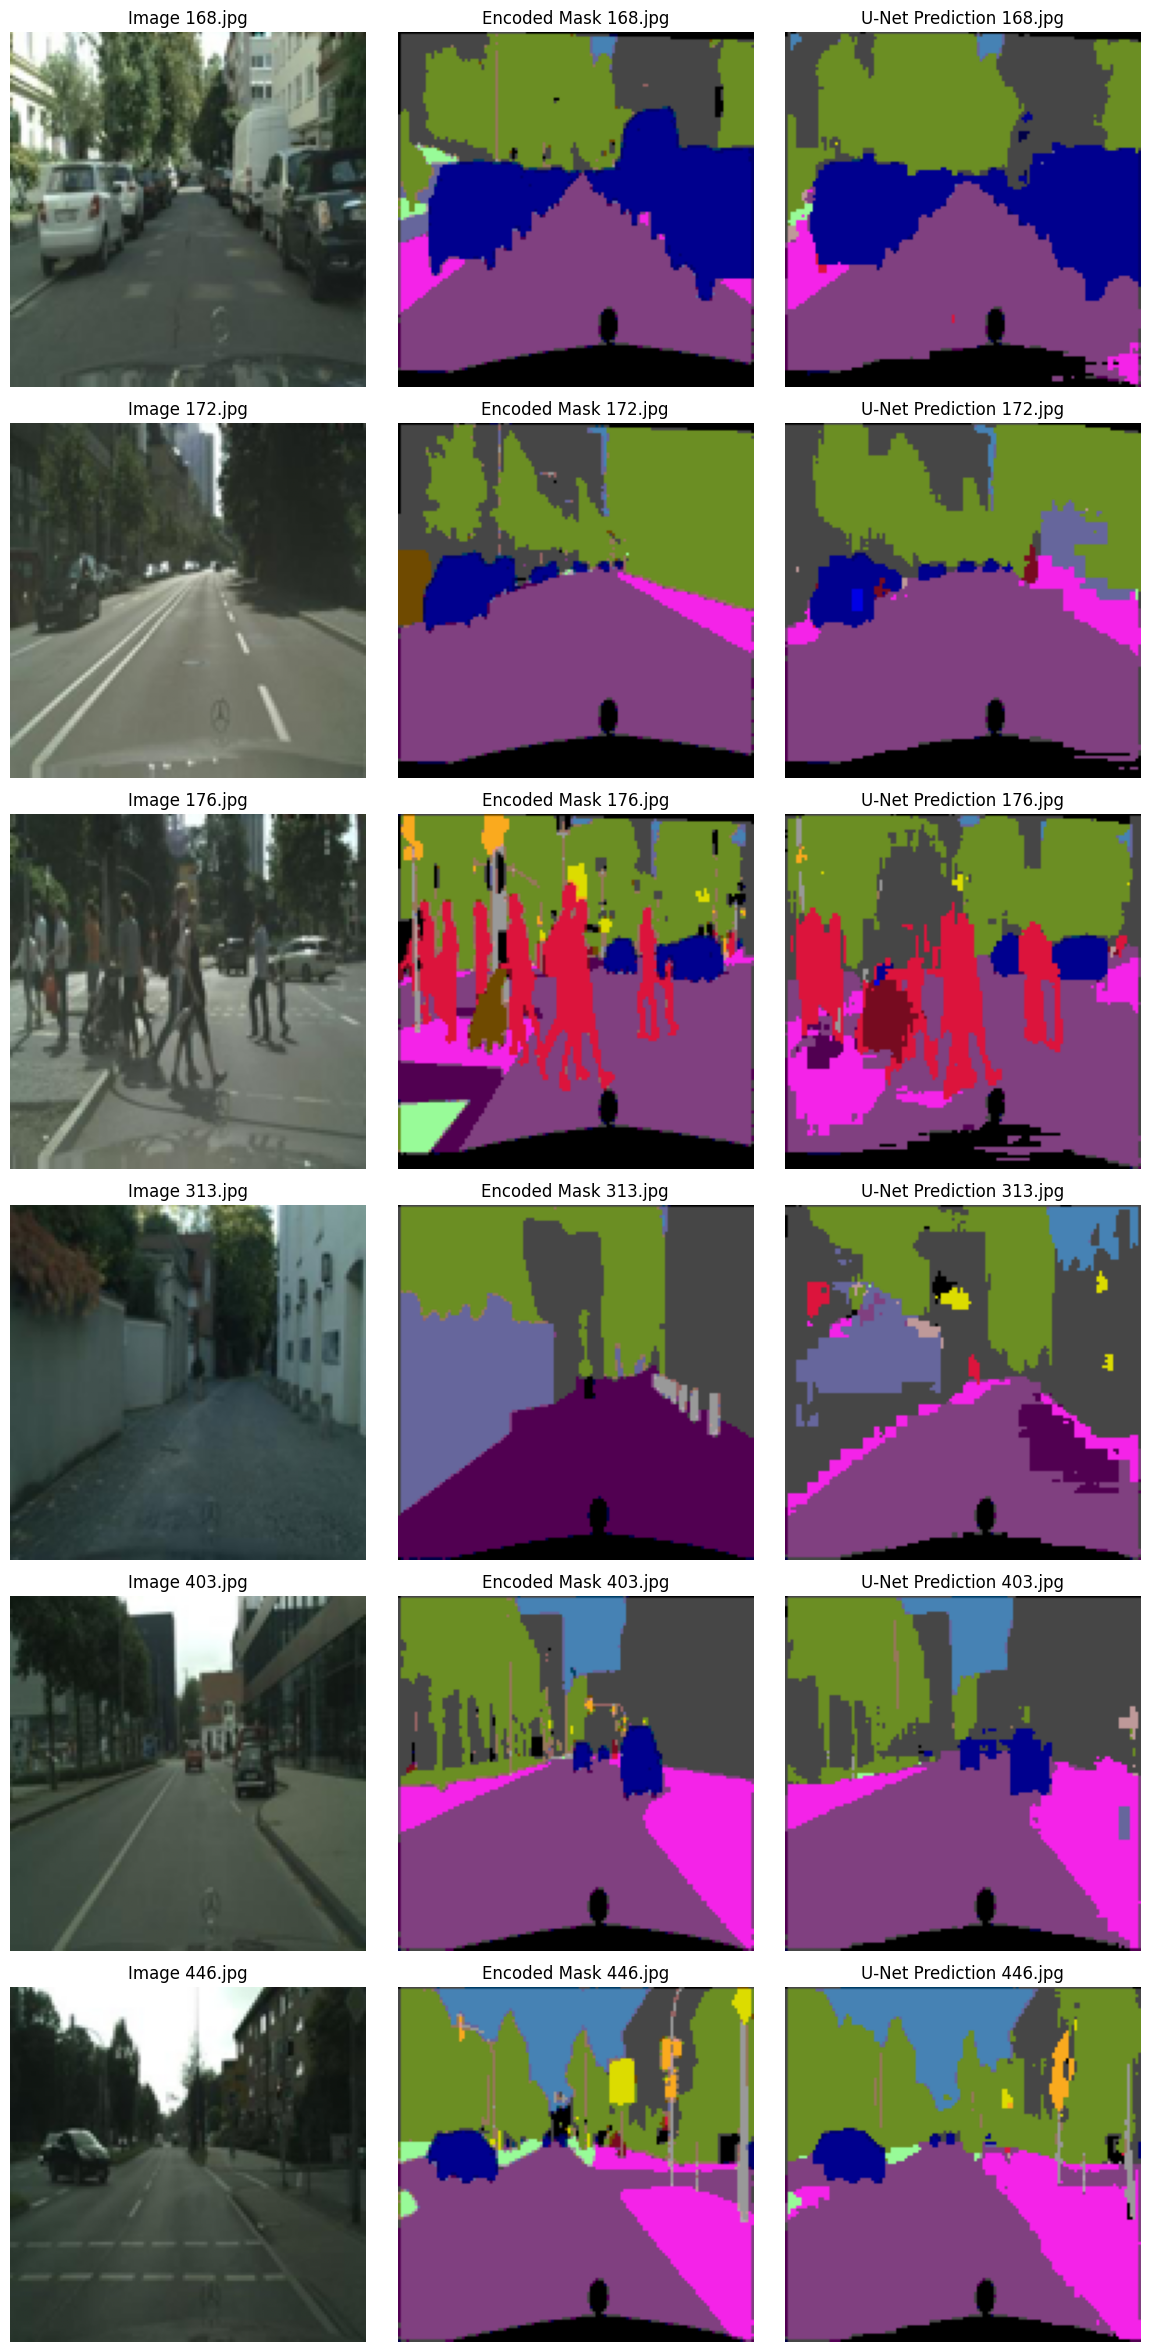

In [ ]:
plt.style.use("default")
samples = [168, 172, 176, 313, 403, 446]
plt.figure(figsize=[15, len(samples) * 5])
names = [f'{_}.jpg' for _ in samples]
for i, name in enumerate(names):
# for i, name in enumerate(os.listdir(val_path)[:4]):
    img, mask, _ = preprocess(os.path.join(val_path,name),IMAGE_SIZE)
    pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))

    tmp1 = np.zeros([mask.shape[0], mask.shape[1], 3])
    tmp2 = np.zeros([mask.shape[0], mask.shape[1], 3])


    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            tmp1[row, col, :] = id2color[mask[row, col]]
            tmp1 = tmp1.astype('uint8')

            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')

    plt.subplot(len(samples), 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(name))

    plt.subplot(len(samples), 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(name))

    plt.subplot(len(samples), 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('U-Net Prediction {}'.format(name))
    plt.savefig(f'pic{i}.jpg')
    # plt.close()

plt.subplots_adjust(wspace=0, hspace=0.1)


# **Evaluation**

In [ ]:
def create_mask(image_data,mask_data, model):
    true_masks, predicted_masks = [], []
    for images, masks in zip(image_data, mask_data):
        pred_masks = model.predict(images.reshape([1] + IMAGE_SHAPE))
        pred_masks = tf.squeeze(tf.argmax(pred_masks, axis=-1))
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)

    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)

    return true_masks, predicted_masks

In [ ]:
# true_train_masks, predicted_train_masks = create_mask(train_images,train_masks_enc, model)

In [ ]:
true_validation_masks, predicted_validation_masks = create_mask(val_images, val_masks_enc, model)

1/1 [==============================] - 0s 21ms/step



## Evaluate Predicted Segmentations

In [ ]:
def evaluate_model(true_masks, predicted_masks, n_classes, smooth = 1e-6):

    """
    Evaluates semantic segmentation model

    Argument:
        true_masks: ground truth segmentations
        predicted_masks: predicted segmentations
        n_classes: number of segmentation classes
        smooth: a minute float digit added to denominators to avoid error from a zero division

    Returns:
        class_wise_evaluations: a dictionary containing evaluation metric
                                outputs the for each segmentation class
        overall_evaluations: a dictionary containing evaluation metric
                             outputs the for all segmentation classes
        """
    # Create empty lists to store evaluation metric outputs
    class_wise_true_positives, class_wise_true_negatives = [],[]
    class_wise_false_positives, class_wise_false_negatives = [],[]
    class_wise_precisions, class_wise_recalls = [],[]
    class_wise_specificities, class_wise_ious = [],[]
    class_wise_tdrs, class_wise_f1_scores = [],[]
    class_wise_dices = []
    classes, classes_name = [], []

    for clas in range(n_classes):
        true_positives, true_negatives, false_positives, false_negatives = 0,0,0,0
        precisions, recalls, specificities, ious, f1_scores, tdrs = 0,0,0,0,0,0

        number_of_masks = true_masks.shape[0]

        for mask_id in range(number_of_masks):
            true_positive = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]==clas))
            true_negative = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]!=clas))
            false_positive = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]==clas))
            false_negative = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]!=clas))

            true_positives += true_positive
            true_negatives += true_negative
            false_positives += false_positive
            false_negatives += false_negative

        recall = round(true_positives/(true_positives + false_negatives + smooth), 2)
        precision = round(true_positives/(true_positives + false_positives + smooth), 2)
        specificity = round(true_negatives/(true_negatives + false_positives + smooth), 2)
        tdr = round((1 - (false_negatives/(true_positives + false_negatives + smooth))), 2)
        iou = round(true_positives/(true_positives + false_negatives + false_positives + smooth), 2)
        f1_score = round((2 * precision * recall)/(precision + recall + smooth), 2)
        dice = round(2 * true_positives/(2 * true_positives + false_negatives + false_positives + smooth), 2)

        class_wise_true_positives.append(true_positives)
        class_wise_true_negatives.append(true_negatives)
        class_wise_false_positives.append(false_positives)
        class_wise_false_negatives.append(false_negatives)
        class_wise_recalls.append(recall)
        class_wise_precisions.append(precision)
        class_wise_specificities.append(specificity)
        class_wise_ious.append(iou)
        class_wise_tdrs.append(tdr)
        class_wise_f1_scores.append(f1_score)
        class_wise_dices.append(dice)
        classes.append("Class " + str(clas+1))
        classes_name.append(labels[clas].name)
        # class_wise_pixel_accuracies.append(pixel_accuracy)

    total_true_positives = np.sum(class_wise_true_positives)
    total_true_negatives = np.sum(class_wise_true_negatives)
    total_false_positives = np.sum(class_wise_false_positives)
    total_false_negatives = np.sum(class_wise_false_negatives)
    mean_recall = round(np.average(np.array(class_wise_recalls)), 2)
    mean_precision = round(np.average(np.array(class_wise_precisions)), 2)
    mean_specificity = round(np.average(np.array(class_wise_specificities)), 2)
    mean_iou = round(np.average(np.array(class_wise_ious)), 2)
    mean_tdr = round(np.average(np.array(class_wise_tdrs)), 2)
    mean_f1_score = round(np.average(np.array(class_wise_f1_scores)), 2)
    mean_dice = round(np.average(np.array(class_wise_dices)), 2)


    class_wise_evaluations = {"Class": classes,
                              "Name": classes_name,
                              "True Positive Pixels": class_wise_true_positives,
                              "True Negative Pixels": class_wise_true_negatives,
                              "False Positive Pixels": class_wise_false_positives,
                              "False Negative Pixels": class_wise_false_negatives,
                              "Recall": class_wise_recalls,
                              "Precision": class_wise_precisions,
                              "Specificity": class_wise_specificities,
                              "IoU": class_wise_ious,
                              "Dice": class_wise_dices,
                              "TDR": class_wise_tdrs,
                              "F1-Score": class_wise_f1_scores}

    overall_evaluations = {"Class": "All Classes",
                           "Name": "All",
                        "True Positive Pixels": total_true_positives,
                        "True Negative Pixels": total_true_negatives,
                        "False Positive Pixels": total_false_positives,
                        "False Negative Pixels": total_false_negatives,
                        "Recall": mean_recall,
                        "Precision": mean_precision,
                        "Specificity": mean_specificity,
                        "IoU": mean_iou,
                        "Dice": mean_dice,
                        "TDR": mean_tdr,
                        "F1-Score": mean_f1_score}

    evaluations = {"Overall Evaluations": overall_evaluations,
                   "Class-wise Evaluations": class_wise_evaluations}

    return evaluations

In [ ]:
def show_evaluations(evaluations,
                     metrics=["Recall", "Precision", "Specificity", "IoU", "Dice", "TDR", "F1 Score"],
                     class_list=None,
                     display_evaluations="All"):
    """
    Returns a pandas dataframe containing specified metrics

        Arguments:
            evaluations: evaluation output from the evaluate_model function
            metrics: a list containing one or more of the following metrics:
                     'True Positive', 'True Negative', 'False Positive', 'False Negative',
                     'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'
            display_evaluations: one of 'All' to display both overall and class-wise evaluations,
                                 'Overall' to display only the overall evaluations,
                                 'Class-wise' to display only the classwise evaluations.
            class_list: list or tuple containing names of segmentation class.
    """

    # Split evaluations into overall and class-wise evaluations
    overall_evaluations = evaluations["Overall Evaluations"]
    class_wise_evaluations = evaluations["Class-wise Evaluations"]

    # Validate list of metrics
    for metric_id in range(len(metrics)):
        metric = metrics[metric_id]
        if metric not in overall_evaluations:
            raise ValueError("'metrics argument' not properly defined. "
                            "Kindly create a list containing one or more of the following metrics: "
                             "'True Positive', 'True Negative', 'False Positive', 'False Negative', "
                             "'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'")

    # Check if class_list is none
    if class_list != None and all(isinstance(class_, str) for class_ in class_list):
        if len(class_list) == len(class_wise_evaluations["Class"]):
            class_list = [class_list]
        else:
            raise ValueError("class_list argument' not properly defined. "
                             "List is either shorter or longer than segmentation classes")
    else:
        class_list = [class_wise_evaluations["Class"]]
        class_name = [class_wise_evaluations["Name"]]

    # Extract data from the evaluations
    overall_data = [overall_evaluations["Class"], "All"] + [overall_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    classwise_data = class_list + class_name + [class_wise_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    overall_data = np.array(overall_data).reshape(1,-1)
    classwise_data = np.array(classwise_data).transpose()

    # Determine the type of evaluation report to display
    if display_evaluations.lower() == "all":
        data = np.concatenate((overall_data, classwise_data), axis=0)
    elif display_evaluations.lower() == "overall":
        data = overall_data
    elif display_evaluations.lower() == "class-wise" or "classwise":
        data = classwise_data
    else:
        raise ValueError("Display argument are not properly defined."
                        "Kindly use 'All' to display both overall and class-wise evaluations."
                        "Use 'Overall' to display only the overall evaluations."
                        "Or use 'Class-wise' to display only the class-wise evaluations")


    # Create evaluation report as a pandas dataframe
    dataframe = pd.DataFrame(data)
    dataframe_titles = ["Class", "Name"] + metrics
    dataframe.columns = dataframe_titles
    # dataframe = dataframe.set_index(dataframe_titles[0], col_level=1)

    return dataframe

## Evaluate with each class on val set

In [ ]:
model_evaluation_on_validation_dataset = evaluate_model(true_validation_masks, predicted_validation_masks, n_classes=num_classes)

In [ ]:
# full metrics=["Recall", "Precision", "Specificity", "IoU", "Dice", "TDR", "F1-Score"],
df = show_evaluations(model_evaluation_on_validation_dataset,
                 metrics=["IoU", "Dice"],
                 class_list=None,
                 display_evaluations="All")

df
# df.sort_values(by='IoU', ascending=False, ignore_index=True)

,Class,Name,IoU,Dice
0,All Classes,All,0.22,0.3
1,Class 1,unlabeled,0.74,0.85
2,Class 2,ego vehicle,0.0,0.0
3,Class 3,rectification border,0.0,0.0
4,Class 4,out of roi,0.0,0.0
5,Class 5,static,0.0,0.0
6,Class 6,dynamic,0.01,0.01
7,Class 7,ground,0.12,0.22
8,Class 8,road,0.85,0.92
9,Class 9,sidewalk,0.51,0.67
